In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

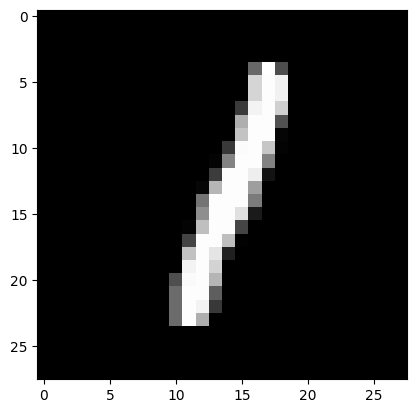

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

images, labels = next(iter(train_loader))
plt.imshow(images[0,0], cmap='gray', vmin=-1, vmax=1)

In [3]:
def sinusoidal_embedding(t, dim):
    device = t.device
    freqs = torch.exp(-torch.arange(dim // 2, device=device) * (torch.log(torch.tensor(10000.0, device=device)) / (dim // 2)))
    args = t[:, None].float() * freqs[None]
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=1)
    return emb

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.SiLU(),
            nn.GroupNorm(1, out_channels),
        )

        self.t_emb_proj = nn.Linear(t_emb_dim, out_channels)

        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.SiLU(),
            nn.GroupNorm(1, out_channels)
        )

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.shortcut = nn.Identity()
    
    def forward(self, x, t_emb):
        h = self.conv1(x)
        t_emb = self.t_emb_proj(t_emb)[:, :, None, None]
        h = h + t_emb
        h = self.conv2(h)
        return h + self.shortcut(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim):
        super().__init__()
        self.block1 = ResidualBlock(in_channels, out_channels, t_emb_dim)
        self.block2 = ResidualBlock(out_channels, out_channels, t_emb_dim)
        self.down = nn.Conv2d(out_channels, out_channels, 4, 2, 1)

    def forward(self, x, t_emb):
        x = self.block1(x, t_emb)
        x = self.block2(x, t_emb)
        skip = x
        x = self.down(x)
        return x, skip

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim):
        super().__init__()
        self.block1 = ResidualBlock(in_channels + in_channels, out_channels, t_emb_dim)
        self.block2 = ResidualBlock(out_channels, out_channels, t_emb_dim)
        self.up = nn.ConvTranspose2d(out_channels, out_channels, 4, 2, 1)

    def forward(self, x, skip, t_emb):
        x = F.interpolate(x, size=skip.shape[-2:], mode='nearest')
        x = torch.cat([x, skip], dim=1)
        x = self.block1(x, t_emb)
        x = self.block2(x, t_emb)
        x = self.up(x)
        return x

class DDPM(nn.Module):
    def __init__(self, in_channels=1, base_channels=64, emb_dim=128, num_classes=10):
        super().__init__()

        # time embedding MLP
        self.time_mlp = nn.Sequential(
            nn.Linear(emb_dim, emb_dim * 4),
            nn.SiLU(),
            nn.Linear(emb_dim * 4, emb_dim)
        )

        # class embedding
        self.class_emb = nn.Embedding(num_classes, emb_dim)

        # encoder
        self.down1 = Down(in_channels, base_channels, emb_dim)
        self.down2 = Down(base_channels, base_channels * 2, emb_dim)

        # bottleneck
        self.bot1 = ResidualBlock(base_channels * 2, base_channels * 2, emb_dim)
        self.bot2 = ResidualBlock(base_channels * 2, base_channels * 2, emb_dim)

        # decoder
        self.up1 = Up(base_channels * 2, base_channels, emb_dim)
        self.up2 = ResidualBlock(base_channels, base_channels, emb_dim)

        self.final = nn.Conv2d(base_channels, in_channels, 1)

    def forward(self, x, t, y):
        t_emb = sinusoidal_embedding(t, self.time_mlp[0].in_features)
        t_emb = self.time_mlp(t_emb)
        c_emb = self.class_emb(y)

        emb = t_emb + c_emb

        x1, skip1 = self.down1(x, emb)
        x2, skip2 = self.down2(x1, emb)
        x3 = self.bot1(x2, emb)
        x3 = self.bot2(x3, emb)
        x4 = self.up1(x3, skip2, emb)
        x5 = self.up2(x4, emb)
        out = self.final(x5)
        return out

In [12]:
device = "cpu"
T = 1000
betas = torch.linspace(1e-4, 0.02, T, device=device)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

In [ ]:

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

model = DDPM()
model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=1e-4)

epochs = 100
for epoch in range(epochs):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for x0, y in pbar:
        x0 = x0.to(device)
        y = y.to(device)

        t = torch.randint(0, T, (x0.shape[0],), device=device).long()
        noise = torch.randn_like(x0)
        alpha_bar_t = extract(alphas_cumprod, t, x0.shape)

        xt = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * noise
        noise_pred = model(xt, t, y)

        loss = F.mse_loss(noise_pred, noise)

        optim.zero_grad()
        loss.backward()
        optim.step()

        pbar.set_postfix(loss=loss.item())
    
    print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")
torch.save(model.state_dict(), "data/model.pth")


Epoch 1/100: 100%|██████████| 469/469 [00:11<00:00, 39.56it/s, loss=0.0471]


Epoch 1 | Loss: 0.0471


Epoch 2/100: 100%|██████████| 469/469 [00:11<00:00, 40.65it/s, loss=0.0427]


Epoch 2 | Loss: 0.0427


Epoch 3/100: 100%|██████████| 469/469 [00:11<00:00, 40.67it/s, loss=0.0371]


Epoch 3 | Loss: 0.0371


Epoch 4/100: 100%|██████████| 469/469 [00:11<00:00, 40.76it/s, loss=0.0408]


Epoch 4 | Loss: 0.0408


Epoch 5/100: 100%|██████████| 469/469 [00:11<00:00, 40.69it/s, loss=0.0328]


Epoch 5 | Loss: 0.0328


Epoch 6/100: 100%|██████████| 469/469 [00:11<00:00, 40.71it/s, loss=0.0285]


Epoch 6 | Loss: 0.0285


Epoch 7/100: 100%|██████████| 469/469 [00:11<00:00, 40.54it/s, loss=0.0324]


Epoch 7 | Loss: 0.0324


Epoch 8/100: 100%|██████████| 469/469 [00:11<00:00, 40.76it/s, loss=0.0329]


Epoch 8 | Loss: 0.0329


Epoch 9/100: 100%|██████████| 469/469 [00:11<00:00, 40.68it/s, loss=0.0231]


Epoch 9 | Loss: 0.0231


Epoch 10/100: 100%|██████████| 469/469 [00:11<00:00, 40.60it/s, loss=0.0299]


Epoch 10 | Loss: 0.0299


Epoch 11/100: 100%|██████████| 469/469 [00:11<00:00, 40.63it/s, loss=0.0276]


Epoch 11 | Loss: 0.0276


Epoch 12/100: 100%|██████████| 469/469 [00:11<00:00, 40.59it/s, loss=0.0244]


Epoch 12 | Loss: 0.0244


Epoch 13/100: 100%|██████████| 469/469 [00:11<00:00, 40.57it/s, loss=0.0259]


Epoch 13 | Loss: 0.0259


Epoch 14/100: 100%|██████████| 469/469 [00:11<00:00, 40.57it/s, loss=0.0329]


Epoch 14 | Loss: 0.0329


Epoch 15/100: 100%|██████████| 469/469 [00:11<00:00, 40.68it/s, loss=0.0257]


Epoch 15 | Loss: 0.0257


Epoch 16/100: 100%|██████████| 469/469 [00:11<00:00, 41.11it/s, loss=0.0262]


Epoch 16 | Loss: 0.0262


Epoch 17/100: 100%|██████████| 469/469 [00:11<00:00, 41.07it/s, loss=0.0262]


Epoch 17 | Loss: 0.0262


Epoch 18/100: 100%|██████████| 469/469 [00:11<00:00, 41.03it/s, loss=0.0259]


Epoch 18 | Loss: 0.0259


Epoch 19/100: 100%|██████████| 469/469 [00:11<00:00, 41.10it/s, loss=0.0279]


Epoch 19 | Loss: 0.0279


Epoch 20/100: 100%|██████████| 469/469 [00:11<00:00, 41.11it/s, loss=0.0268]


Epoch 20 | Loss: 0.0268


Epoch 21/100: 100%|██████████| 469/469 [00:11<00:00, 41.00it/s, loss=0.0249]


Epoch 21 | Loss: 0.0249


Epoch 22/100: 100%|██████████| 469/469 [00:11<00:00, 41.05it/s, loss=0.0205]


Epoch 22 | Loss: 0.0205


Epoch 23/100: 100%|██████████| 469/469 [00:11<00:00, 41.09it/s, loss=0.0253]


Epoch 23 | Loss: 0.0253


Epoch 24/100: 100%|██████████| 469/469 [00:11<00:00, 41.08it/s, loss=0.0215]


Epoch 24 | Loss: 0.0215


Epoch 25/100: 100%|██████████| 469/469 [00:11<00:00, 40.93it/s, loss=0.0252]


Epoch 25 | Loss: 0.0252


Epoch 26/100: 100%|██████████| 469/469 [00:11<00:00, 41.05it/s, loss=0.0196]


Epoch 26 | Loss: 0.0196


Epoch 27/100: 100%|██████████| 469/469 [00:11<00:00, 41.11it/s, loss=0.0268]


Epoch 27 | Loss: 0.0268


Epoch 28/100: 100%|██████████| 469/469 [00:11<00:00, 41.02it/s, loss=0.0217]


Epoch 28 | Loss: 0.0217


Epoch 29/100: 100%|██████████| 469/469 [00:11<00:00, 41.09it/s, loss=0.0281]


Epoch 29 | Loss: 0.0281


Epoch 30/100: 100%|██████████| 469/469 [00:11<00:00, 40.99it/s, loss=0.0178]


Epoch 30 | Loss: 0.0178


Epoch 31/100: 100%|██████████| 469/469 [00:11<00:00, 41.08it/s, loss=0.0248]


Epoch 31 | Loss: 0.0248


Epoch 32/100: 100%|██████████| 469/469 [00:11<00:00, 40.93it/s, loss=0.0218]


Epoch 32 | Loss: 0.0218


Epoch 33/100: 100%|██████████| 469/469 [00:11<00:00, 41.01it/s, loss=0.0232]


Epoch 33 | Loss: 0.0232


Epoch 34/100: 100%|██████████| 469/469 [00:11<00:00, 41.02it/s, loss=0.0293]


Epoch 34 | Loss: 0.0293


Epoch 35/100: 100%|██████████| 469/469 [00:11<00:00, 41.10it/s, loss=0.0231]


Epoch 35 | Loss: 0.0231


Epoch 36/100: 100%|██████████| 469/469 [00:11<00:00, 41.03it/s, loss=0.0177]


Epoch 36 | Loss: 0.0177


Epoch 37/100: 100%|██████████| 469/469 [00:11<00:00, 41.08it/s, loss=0.0211]


Epoch 37 | Loss: 0.0211


Epoch 38/100: 100%|██████████| 469/469 [00:11<00:00, 41.00it/s, loss=0.019] 


Epoch 38 | Loss: 0.0190


Epoch 39/100: 100%|██████████| 469/469 [00:11<00:00, 41.00it/s, loss=0.0315]


Epoch 39 | Loss: 0.0315


Epoch 40/100: 100%|██████████| 469/469 [00:11<00:00, 41.03it/s, loss=0.0235]


Epoch 40 | Loss: 0.0235


Epoch 41/100: 100%|██████████| 469/469 [00:11<00:00, 40.98it/s, loss=0.0186]


Epoch 41 | Loss: 0.0186


Epoch 42/100: 100%|██████████| 469/469 [00:11<00:00, 41.02it/s, loss=0.0209]


Epoch 42 | Loss: 0.0209


Epoch 43/100: 100%|██████████| 469/469 [00:11<00:00, 40.97it/s, loss=0.0239]


Epoch 43 | Loss: 0.0239


Epoch 44/100: 100%|██████████| 469/469 [00:11<00:00, 41.07it/s, loss=0.0206]


Epoch 44 | Loss: 0.0206


Epoch 45/100: 100%|██████████| 469/469 [00:11<00:00, 41.05it/s, loss=0.0235]


Epoch 45 | Loss: 0.0235


Epoch 46/100: 100%|██████████| 469/469 [00:11<00:00, 40.99it/s, loss=0.0201]


Epoch 46 | Loss: 0.0201


Epoch 47/100: 100%|██████████| 469/469 [00:11<00:00, 41.03it/s, loss=0.0197]


Epoch 47 | Loss: 0.0197


Epoch 48/100: 100%|██████████| 469/469 [00:11<00:00, 40.99it/s, loss=0.0235]


Epoch 48 | Loss: 0.0235


Epoch 49/100: 100%|██████████| 469/469 [00:11<00:00, 40.92it/s, loss=0.0245]


Epoch 49 | Loss: 0.0245


Epoch 50/100: 100%|██████████| 469/469 [00:11<00:00, 41.06it/s, loss=0.0212]


Epoch 50 | Loss: 0.0212


Epoch 51/100: 100%|██████████| 469/469 [00:11<00:00, 41.07it/s, loss=0.0177]


Epoch 51 | Loss: 0.0177


Epoch 52/100: 100%|██████████| 469/469 [00:11<00:00, 40.97it/s, loss=0.017] 


Epoch 52 | Loss: 0.0170


Epoch 53/100: 100%|██████████| 469/469 [00:11<00:00, 40.93it/s, loss=0.0241]


Epoch 53 | Loss: 0.0241


Epoch 54/100: 100%|██████████| 469/469 [00:11<00:00, 40.99it/s, loss=0.0285]


Epoch 54 | Loss: 0.0285


Epoch 55/100: 100%|██████████| 469/469 [00:11<00:00, 40.96it/s, loss=0.0169]


Epoch 55 | Loss: 0.0169


Epoch 56/100: 100%|██████████| 469/469 [00:11<00:00, 40.88it/s, loss=0.0244]


Epoch 56 | Loss: 0.0244


Epoch 57/100: 100%|██████████| 469/469 [00:11<00:00, 41.03it/s, loss=0.0218]


Epoch 57 | Loss: 0.0218


Epoch 58/100: 100%|██████████| 469/469 [00:11<00:00, 41.03it/s, loss=0.0218]


Epoch 58 | Loss: 0.0218


Epoch 59/100: 100%|██████████| 469/469 [00:11<00:00, 40.97it/s, loss=0.0266]


Epoch 59 | Loss: 0.0266


Epoch 60/100: 100%|██████████| 469/469 [00:11<00:00, 40.89it/s, loss=0.0224]


Epoch 60 | Loss: 0.0224


Epoch 61/100: 100%|██████████| 469/469 [00:11<00:00, 40.98it/s, loss=0.0219]


Epoch 61 | Loss: 0.0219


Epoch 62/100: 100%|██████████| 469/469 [00:11<00:00, 40.90it/s, loss=0.0212]


Epoch 62 | Loss: 0.0212


Epoch 63/100: 100%|██████████| 469/469 [00:11<00:00, 40.98it/s, loss=0.0223]


Epoch 63 | Loss: 0.0223


Epoch 64/100: 100%|██████████| 469/469 [00:11<00:00, 41.04it/s, loss=0.0271]


Epoch 64 | Loss: 0.0271


Epoch 65/100: 100%|██████████| 469/469 [00:11<00:00, 40.88it/s, loss=0.0213]


Epoch 65 | Loss: 0.0213


Epoch 66/100: 100%|██████████| 469/469 [00:11<00:00, 41.03it/s, loss=0.0247]


Epoch 66 | Loss: 0.0247


Epoch 67/100: 100%|██████████| 469/469 [00:11<00:00, 41.04it/s, loss=0.0233]


Epoch 67 | Loss: 0.0233


Epoch 68/100: 100%|██████████| 469/469 [00:11<00:00, 40.89it/s, loss=0.018] 


Epoch 68 | Loss: 0.0180


Epoch 69/100: 100%|██████████| 469/469 [00:11<00:00, 40.98it/s, loss=0.0172]


Epoch 69 | Loss: 0.0172


Epoch 70/100: 100%|██████████| 469/469 [00:11<00:00, 40.97it/s, loss=0.0224]


Epoch 70 | Loss: 0.0224


Epoch 71/100: 100%|██████████| 469/469 [00:11<00:00, 40.89it/s, loss=0.0213]


Epoch 71 | Loss: 0.0213


Epoch 72/100: 100%|██████████| 469/469 [00:11<00:00, 41.04it/s, loss=0.0191]


Epoch 72 | Loss: 0.0191


Epoch 73/100: 100%|██████████| 469/469 [00:11<00:00, 40.98it/s, loss=0.0179]


Epoch 73 | Loss: 0.0179


Epoch 74/100: 100%|██████████| 469/469 [00:11<00:00, 40.99it/s, loss=0.0233]


Epoch 74 | Loss: 0.0233


Epoch 75/100: 100%|██████████| 469/469 [00:11<00:00, 41.03it/s, loss=0.0227]


Epoch 75 | Loss: 0.0227


Epoch 76/100: 100%|██████████| 469/469 [00:11<00:00, 41.01it/s, loss=0.0216]


Epoch 76 | Loss: 0.0216


Epoch 77/100: 100%|██████████| 469/469 [00:11<00:00, 40.94it/s, loss=0.019] 


Epoch 77 | Loss: 0.0190


Epoch 78/100: 100%|██████████| 469/469 [00:11<00:00, 41.07it/s, loss=0.0225]


Epoch 78 | Loss: 0.0225


Epoch 79/100: 100%|██████████| 469/469 [00:11<00:00, 40.04it/s, loss=0.0216]


Epoch 79 | Loss: 0.0216


Epoch 80/100: 100%|██████████| 469/469 [00:11<00:00, 40.33it/s, loss=0.0208]


Epoch 80 | Loss: 0.0208


Epoch 81/100: 100%|██████████| 469/469 [00:11<00:00, 40.02it/s, loss=0.018] 


Epoch 81 | Loss: 0.0180


Epoch 82/100: 100%|██████████| 469/469 [00:11<00:00, 40.44it/s, loss=0.0286]


Epoch 82 | Loss: 0.0286


Epoch 83/100: 100%|██████████| 469/469 [00:11<00:00, 40.17it/s, loss=0.0217]


Epoch 83 | Loss: 0.0217


Epoch 84/100: 100%|██████████| 469/469 [00:11<00:00, 40.13it/s, loss=0.0216]


Epoch 84 | Loss: 0.0216


Epoch 85/100: 100%|██████████| 469/469 [00:11<00:00, 39.69it/s, loss=0.0199]


Epoch 85 | Loss: 0.0199


Epoch 86/100: 100%|██████████| 469/469 [00:11<00:00, 39.77it/s, loss=0.0173]


Epoch 86 | Loss: 0.0173


Epoch 87/100: 100%|██████████| 469/469 [00:11<00:00, 40.42it/s, loss=0.0184]


Epoch 87 | Loss: 0.0184


Epoch 88/100: 100%|██████████| 469/469 [00:11<00:00, 40.28it/s, loss=0.0182]


Epoch 88 | Loss: 0.0182


Epoch 89/100: 100%|██████████| 469/469 [00:11<00:00, 40.16it/s, loss=0.0231]


Epoch 89 | Loss: 0.0231


Epoch 90/100: 100%|██████████| 469/469 [00:11<00:00, 39.97it/s, loss=0.0176]


Epoch 90 | Loss: 0.0176


Epoch 91/100: 100%|██████████| 469/469 [00:11<00:00, 40.75it/s, loss=0.0259]


Epoch 91 | Loss: 0.0259


Epoch 92/100: 100%|██████████| 469/469 [00:11<00:00, 39.90it/s, loss=0.0207]


Epoch 92 | Loss: 0.0207


Epoch 93/100: 100%|██████████| 469/469 [00:11<00:00, 40.34it/s, loss=0.0251]


Epoch 93 | Loss: 0.0251


Epoch 94/100: 100%|██████████| 469/469 [00:11<00:00, 40.05it/s, loss=0.0188]


Epoch 94 | Loss: 0.0188


Epoch 95/100: 100%|██████████| 469/469 [00:11<00:00, 40.32it/s, loss=0.0196]


Epoch 95 | Loss: 0.0196


Epoch 96/100: 100%|██████████| 469/469 [00:11<00:00, 40.00it/s, loss=0.0256]


Epoch 96 | Loss: 0.0256


Epoch 97/100: 100%|██████████| 469/469 [00:11<00:00, 40.30it/s, loss=0.0212]


Epoch 97 | Loss: 0.0212


Epoch 98/100: 100%|██████████| 469/469 [00:11<00:00, 40.04it/s, loss=0.0219]


Epoch 98 | Loss: 0.0219


Epoch 99/100: 100%|██████████| 469/469 [00:11<00:00, 39.97it/s, loss=0.0207]


Epoch 99 | Loss: 0.0207


Epoch 100/100: 100%|██████████| 469/469 [00:11<00:00, 40.02it/s, loss=0.0219]


Epoch 100 | Loss: 0.0219


In [29]:
@torch.no_grad()
def p_sample(model, x, t, t_index, betas, alphas, alphas_cumprod):
    beta_t = betas[t_index]
    alpha_t = alphas[t_index]
    alpha_bar_t = alphas_cumprod[t_index]
    sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar_t)

    # predict noise
    eps_theta = model(x, t, torch.arange(0, 10).long())

    # equation for mean
    mean = (1 / torch.sqrt(alpha_t)) * (x - (beta_t / sqrt_one_minus_alpha_bar) * eps_theta)

    # if t > 0, add noise; else, return mean
    if t_index > 0:
        noise = torch.randn_like(x)
        sigma_t = torch.sqrt(beta_t)
        sample = mean + sigma_t * noise
    else:
        sample = mean
    return sample


@torch.no_grad()
def sample_loop(model, image_size, channels, T, betas, alphas, alphas_cumprod, n=10, device="cuda"):
    model.eval()
    x = torch.randn(n, channels, image_size, image_size).to(device)

    for i in tqdm(reversed(range(T)), total=T):
        t = torch.full((n,), i, device=device, dtype=torch.long)
        x = p_sample(model, x, t, i, betas, alphas, alphas_cumprod)
    return x


model = DDPM()
model.to(device)
model.load_state_dict(torch.load("data/model.pth", map_location=device))
samples = sample_loop(model, image_size=28, channels=1, T=T,
                      betas=betas, alphas=alphas,
                      alphas_cumprod=alphas_cumprod,
                      n=10, device=device)
samples = (samples.clamp(-1, 1) + 1) / 2

100%|██████████| 1000/1000 [00:09<00:00, 101.30it/s]


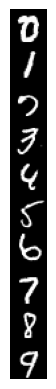

In [40]:
grid = torch.cat([s for s in samples.transpose(2, 3).cpu()], dim=2)
plt.imshow(grid.squeeze(0).T, cmap='gray')
plt.axis('off')
plt.show()